In [73]:
import geopandas
import matplotlib.pyplot as mp
import cartopy
import numpy
import xarray
import cmocean
#import rasterio
import shapely
import itertools

use temperature file as an example

In [30]:
states_gdf = geopandas.read_file('/Users/baird/Dropbox/_shapefiles/_natural_earth_data/ne_110m_admin_1_states_provinces/ne_110m_admin_1_states_provinces.shp')
#coastlines_gs = geopandas.GeoSeries.from_file('/Users/baird/Dropbox/_shapefiles/_natural_earth_data/ne_110m_coastline/ne_110m_coastline.shp')
ca_gdf = states_gdf[states_gdf['iso_3166_2']=='US-CA']
#ca_gdf.crs
#ca_gdf.crs['init'][-4:]
ca_gdf['geometry'].values[0]

In [141]:
coastlines_gdf = geopandas.read_file('/Users/baird/Dropbox/_shapefiles/_natural_earth_data/ne_110m_coastline/ne_110m_coastline.shp')
countries_gdf = geopandas.read_file('/Users/baird/Dropbox/_shapefiles/_natural_earth_data/ne_110m_admin_0_countries/ne_110m_admin_0_countries.shp')

In [142]:
usa_gdf = countries_gdf[countries_gdf['SOVEREIGNT']=='United States of America']

In [143]:
usa_gdf = usa_gdf[usa_gdf['ADM0_A3']=='USA']

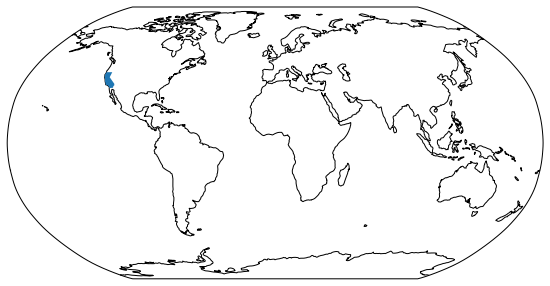

In [144]:
fig = mp.figure(figsize=(10,5))

ax = fig.add_subplot(111, projection=cartopy.crs.Robinson())
ax.coastlines()

ax.add_geometries([ca_gdf.geometry.values[0]], crs=cartopy.crs.PlateCarree())

#ax.add_geometries(coastlines_gdf.geometry, crs=cartopy.crs.PlateCarree())#

In [122]:
lon_pcolormesh = numpy.zeros(ts_lon.size+2)
lon_pcolormesh[1:-1] = ts_lon
lon_pcolormesh[0] = ts_lon[0]-numpy.diff(ts_lon)[0]
lon_pcolormesh[-1] = ts_lon[-1]+numpy.diff(ts_lon)[-1]
lon_pcolormesh_midpoints = lon_pcolormesh[:-1]+0.5*(numpy.diff(lon_pcolormesh))

lat_pcolormesh = numpy.zeros(ts_lat.size+2)
lat_pcolormesh[1:-1] = ts_lat
lat_pcolormesh[0] = ts_lat[0]-numpy.diff(ts_lat)[0]
lat_pcolormesh[-1] = ts_lat[-1]+numpy.diff(ts_lat)[-1]
lat_pcolormesh_midpoints = lat_pcolormesh[:-1]+0.5*(numpy.diff(lat_pcolormesh))

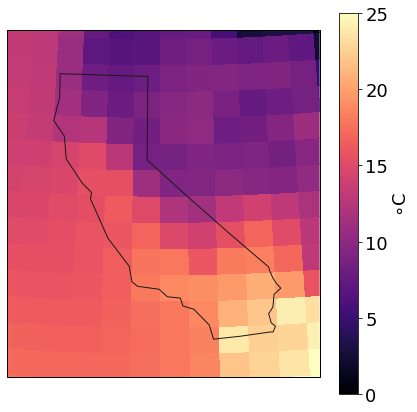

In [138]:
fig = mp.figure(figsize=(7,7))

map_proj = cartopy.crs.LambertConformal(standard_parallels=[lat_lo,lat_hi], \
    central_longitude=0.5*(lon_lo+lon_hi), \
    central_latitude=0.5*(lat_lo+lat_hi))

# data_proj = cartopy.crs.AlbersEqualArea(central_longitude=-96.0, \
#                             central_latitude=23.0, \
#                             false_easting=0.0, \
#                             false_northing=0.0, \
#                             standard_parallels=(29.5, 45.5), \
#                             globe=None)
#ecoregions_proj = cartopy.crs.epsg(ca_gdf.crs['init'].split(':')[1])

lens_proj = cartopy.crs.PlateCarree()

ax = fig.add_subplot(111, projection=map_proj)
ax.set_extent([lon_lo-1, lon_hi+1, lat_lo-1, lat_hi+1])

#ax.add_geometries(CA_object.geometry, crs=cartopy.crs.PlateCarree(), facecolor='None', edgecolor='0')
#ax.add_geometries([sierras_series], crs=ecoregions_proj, facecolor='orange', alpha=0.5)
ax.add_geometries([ca_gdf.geometry.values[0]], crs=cartopy.crs.PlateCarree(), \
                  facecolor='None', edgecolor='0.1')

temps = ax.pcolormesh(lon_pcolormesh_midpoints,lat_pcolormesh_midpoints,ts_data.mean(axis=0)-273.15,\
                      cmap='magma',transform=lens_proj, vmin=0, vmax=25)
cbar = mp.colorbar(temps)
cbar.ax.tick_params(labelsize=18)
cbar.set_label('$\circ$C', fontsize=18)
#fig.savefig('topo_and_sierras_ecoregion.png', dpi=600, bbox_inches='tight', transparent=True)

In [173]:
# not dependent on actual data
latlon_index_combos = numpy.array([i for i in itertools.product(range(ts_lat.size),range(ts_lon.size))])

lat_polygon_hi_list = []
lon_polygon_hi_list = []
lat_polygon_lo_list = []
lon_polygon_lo_list = []

lon_list = []
lat_list = []

for latlon in latlon_index_combos:

    lat_idx = latlon[0]
    lon_idx = latlon[1]
    
    lon_list.append(ts_lon[latlon[1]])
    lat_list.append(ts_lat[latlon[0]])

    lon_polygon_hi_list.append(-360.+lon_pcolormesh_midpoints[lon_idx+1])
    lon_polygon_lo_list.append(-360.+lon_pcolormesh_midpoints[lon_idx])

    lat_polygon_hi_list.append(lat_pcolormesh_midpoints[lat_idx+1])
    lat_polygon_lo_list.append(lat_pcolormesh_midpoints[lat_idx])

polygon_boxes = numpy.array([shapely.geometry.box(i[0],i[1],i[2],i[3]) \
                             for i in zip(lon_polygon_lo_list,lat_polygon_lo_list, \
                                          lon_polygon_hi_list,lat_polygon_hi_list)])

# calculate True/False intersection list of these projected ecoregion polygons
# intersects_TF_list = []
# for box in polygon_boxes:
#     intersects_TF_list.append(ca_gdf['geometry'].values[0].intersects(box))
# latlon_index_combos_intersect = latlon_index_combos[intersects_TF_list]

overlaps_TF_list_california = []
for box in polygon_boxes:
    overlaps_TF_list_california.append(ca_gdf['geometry'].values[0].overlaps(box))
latlon_index_combos_overlap_california = latlon_index_combos[overlaps_TF_list_california]

overlaps_TF_list_country = []
for box in polygon_boxes:
    overlaps_TF_list_country.append(usa_gdf['geometry'].values[0].overlaps(box))
latlon_index_combos_overlap_country = latlon_index_combos[overlaps_TF_list_country]

overlaps_TF_list_ca_and_usa = [overlaps_TF_list_california[i]==True & overlaps_TF_list_country[i]==True \
                               for i in range(overlaps_TF_list_country.__len__())]








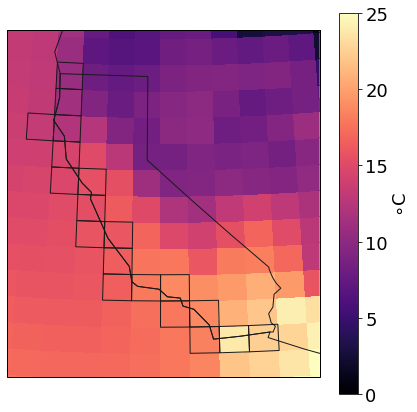

In [174]:
fig = mp.figure(figsize=(7,7))

map_proj = cartopy.crs.LambertConformal(standard_parallels=[lat_lo,lat_hi], \
    central_longitude=0.5*(lon_lo+lon_hi), \
    central_latitude=0.5*(lat_lo+lat_hi))

lens_proj = cartopy.crs.PlateCarree()

ax = fig.add_subplot(111, projection=map_proj)
ax.set_extent([lon_lo-1, lon_hi+1, lat_lo-1, lat_hi+1])

#ax.add_geometries(CA_object.geometry, crs=cartopy.crs.PlateCarree(), facecolor='None', edgecolor='0')
#ax.add_geometries([sierras_series], crs=ecoregions_proj, facecolor='orange', alpha=0.5)
ax.add_geometries([ca_gdf.geometry.values[0]], crs=cartopy.crs.PlateCarree(), \
                  facecolor='None', edgecolor='0.1')

ax.add_geometries([usa_gdf.geometry.values[0]], crs=cartopy.crs.PlateCarree(), \
                  facecolor='None', edgecolor='0.1')

temps = ax.pcolormesh(lon_pcolormesh_midpoints,lat_pcolormesh_midpoints,ts_data.mean(axis=0)-273.15,\
                      cmap='magma',transform=lens_proj, vmin=0, vmax=25)
cbar = mp.colorbar(temps)
cbar.ax.tick_params(labelsize=18)
cbar.set_label('$\circ$C', fontsize=18)

ax.add_geometries(polygon_boxes[overlaps_TF_list_ca_and_usa], crs=cartopy.crs.PlateCarree(), facecolor='None', edgecolor='0.1')
#fig.savefig('topo_and_sierras_ecoregion.png', dpi=600, bbox_inches='tight', transparent=True)

In [28]:
coastlines_gdf.crs

{'init': 'epsg:4326'}

In [2]:
states_shapes = cartopy.io.shapereader.natural_earth(resolution='10m', category='cultural', name='admin_1_states_provinces')
shapes_reader = cartopy.io.shapereader.Reader(states_shapes)

states_name_list = numpy.array(([i.attributes['name'] for i in shapes_reader.records()]))
for i in shapes_reader.records():
    if i.attributes['name']=='California' and i.attributes['iso_a2']=='US':
        CA_object = i
CA_object_no_islands = CA_object.geometry.geoms[-1] # get the last one (the state of Cali)


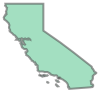

In [5]:
CA_object.geometry

In [6]:
lon_lo, lon_hi, lat_lo, lat_hi = 235.25, 246.25, 32., 42.5

In [13]:
!ls ../../cesm-LE-file

b.e11.B20TRC5CNBDRD.f09_g16.002.cam.h1.TS.19200101-20051231.nc


In [14]:
ncfile = xarray.open_dataset('../../cesm-LE-file/b.e11.B20TRC5CNBDRD.f09_g16.002.cam.h1.TS.19200101-20051231.nc')
ts_data = ncfile['TS'].sel(lat=slice(lat_lo-5,lat_hi+5),lon=slice(lon_lo-5,lon_hi+5)).values
ts_lat = ncfile['lat'].sel(lat=slice(lat_lo-5,lat_hi+5)).values
ts_lon = ncfile['lon'].sel(lon=slice(lon_lo-5,lon_hi+5)).values